2024-10-27 16:40:09.983607: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-27 16:40:10.098059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-27 16:40:10.098075: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-10-27 16:40:10.617528: W tensorflow/compiler/xla/stream_executor/platform/defau

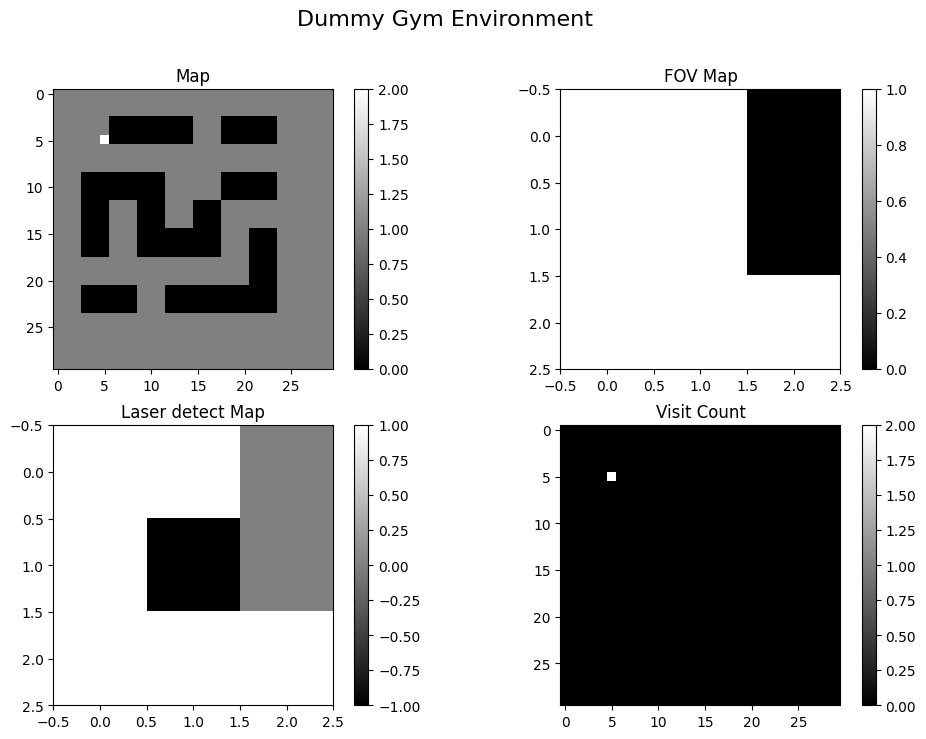

4


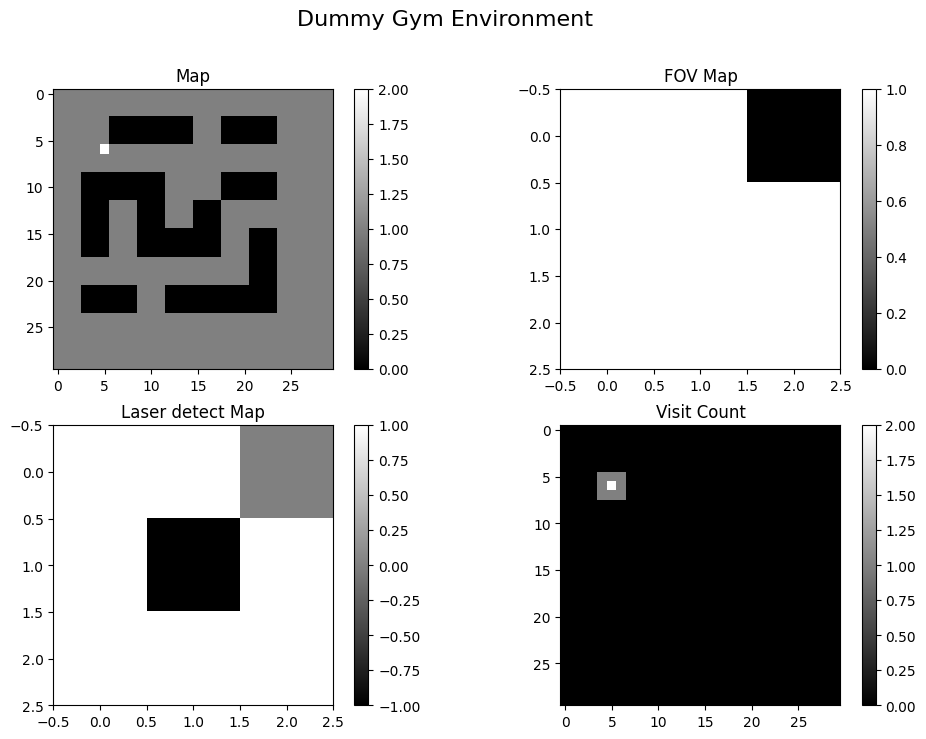

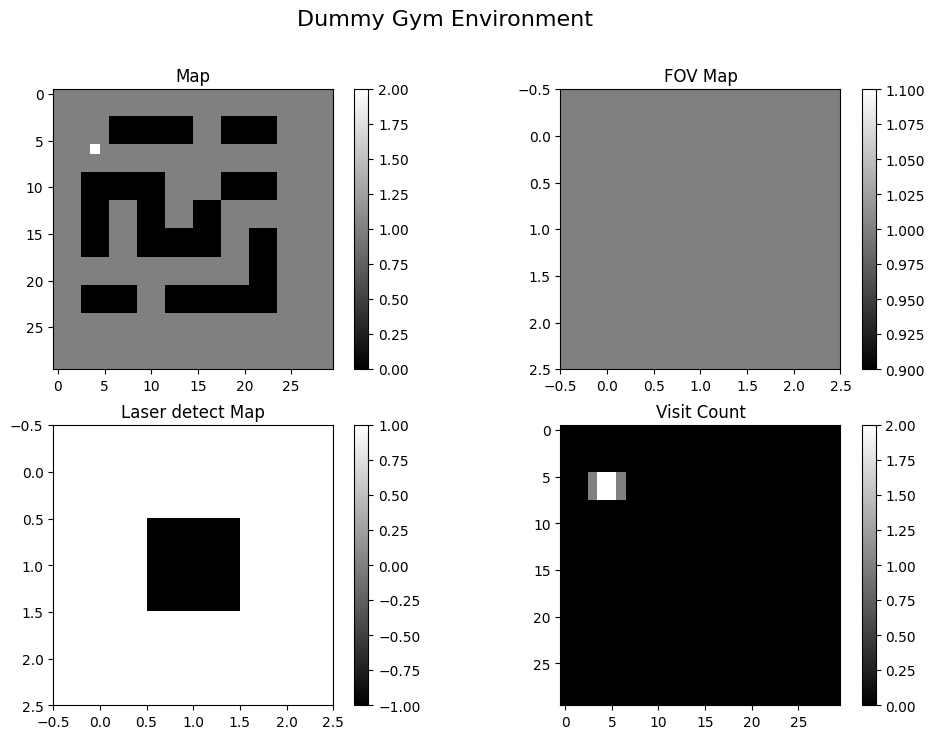

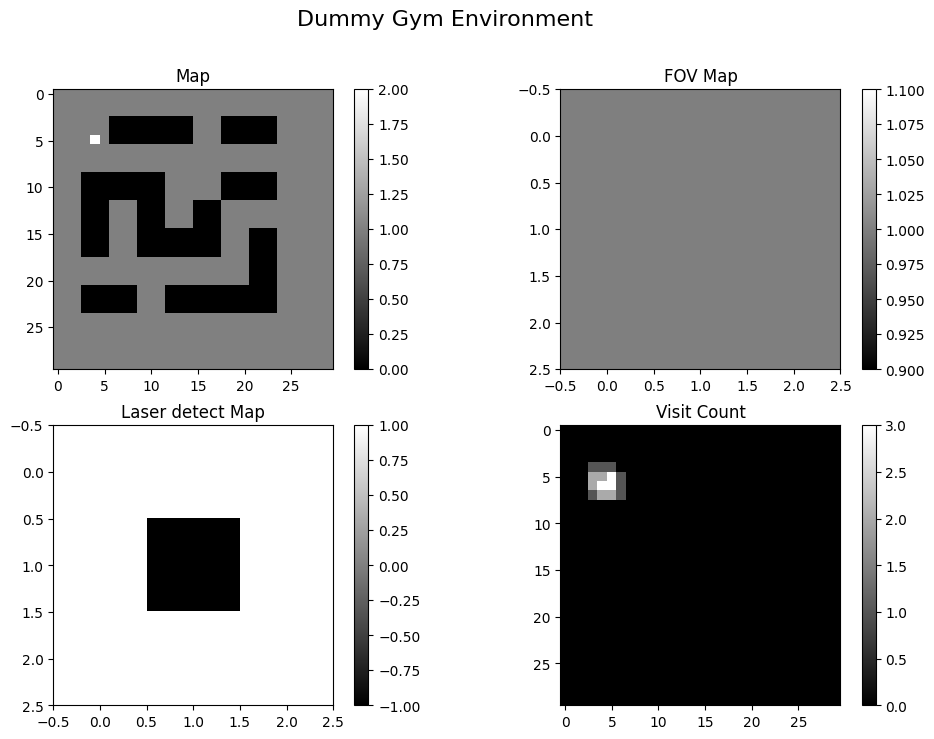

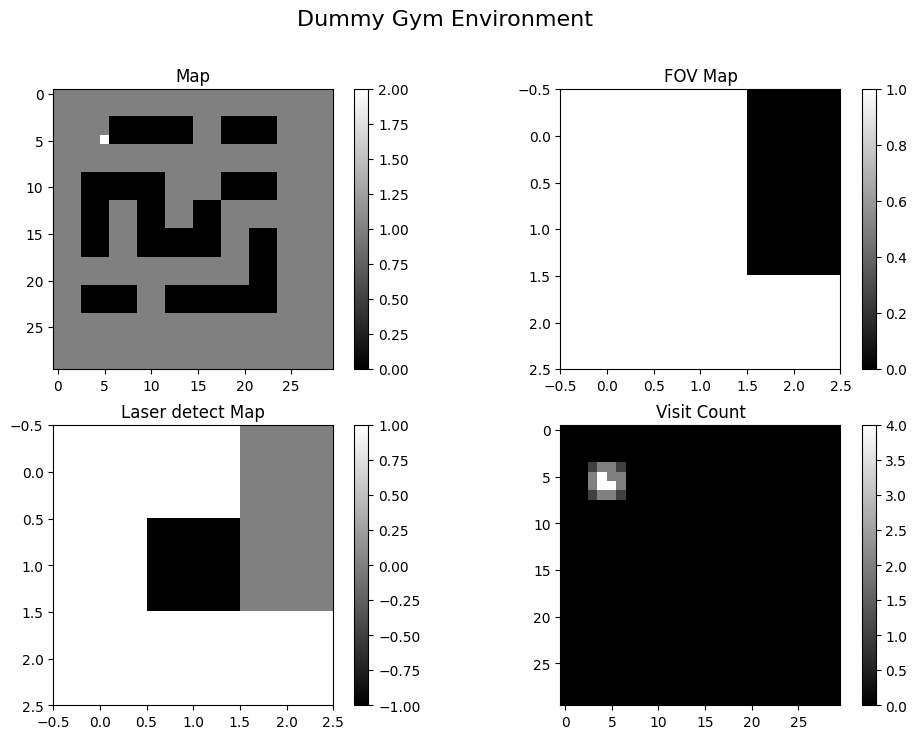

In [1]:
# Import the necessary libraries
import os
os.chdir('/home/zhihan/ME5418')

import gym
import tensorflow as tf
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
from dummy_gym import DummyGym
# print(os.getcwd())

# Create the environment instance
env = DummyGym()


In [2]:
# Hyperparameters
original_state = env.observe()
action_size = env.action_space.n
print(f'action_size is {action_size}')
batch_size = 4
n_episodes = 1
time_steps = 10
epochs = 50

# DQN parameters
gamma = 0.99  # discount rate
epsilon = 1.0  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.995

# Replay buffer
replay_buffer = deque(maxlen=2000)


action_size is 4


In [3]:
# 处理原始state
def prepare_state(original_state):
    visit_count, fov_map, car_pos = original_state
    visit_count, fov_map, car_pos = np.array(visit_count), np.array(fov_map), np.array(car_pos)

    # add channel dimension
    visit_count_state = visit_count.reshape((*visit_count.shape, 1))
    fov_map_state = fov_map.reshape((*fov_map.shape, 1))
    car_pos_state = car_pos.reshape((*car_pos.shape, 1))

    print(type(visit_count_state), type(fov_map_state), type(car_pos_state))
    
    return [visit_count_state, fov_map_state, car_pos_state], [visit_count_state.shape, fov_map_state.shape, car_pos_state.shape]
_, state_shape = prepare_state(original_state)
# print(state_shape[0], state_shape[1], state_shape[2])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [4]:
def create_dqn_model(conv_filters_1=32, conv_filters_2=16, kernel_size=(3,3), dense_units_1=64, dense_units_2=32, pool_size=(2,2), pool=False, dropout=False):
    # Input for state_array[0].shape array(120*120)
    input_visit_count_state = tf.keras.layers.Input(shape=state_shape[0], name='input_visit_count_state')
    conv_visit_count_state = tf.keras.layers.Conv2D(conv_filters_1, kernel_size, activation='relu')(input_visit_count_state)
    # add dropout layer
    if dropout:
        dropout_visit_count_state = tf.keras.layers.Dropout(0.2)(conv_visit_count_state)
    else:
        dropout_visit_count_state = conv_visit_count_state
    if pool:
        pool_visit_count_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_visit_count_state)
    else:
        pool_visit_count_state = dropout_visit_count_state
    flat_visit_count_state = tf.keras.layers.Flatten()(pool_visit_count_state)

    # Input for state_array[1].shape 10x10 array
    input_fov_map = tf.keras.layers.Input(shape=state_shape[1], name='input_fov_map')
    conv_fov_map = tf.keras.layers.Conv2D(conv_filters_2, kernel_size, activation='relu')(input_fov_map)
    if dropout:
        dropout_fov_map_state = tf.keras.layers.Dropout(0.2)(conv_fov_map)
    else:
        dropout_fov_map_state = conv_fov_map
    if pool:
        pool_fov_map_state = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(dropout_fov_map_state)
    else:
        pool_fov_map_state = dropout_fov_map_state
    flat_fov_map = tf.keras.layers.Flatten()(pool_fov_map_state)

    # Input for 2x1 array
    input_car_pos = tf.keras.layers.Input(shape=state_shape[2], name='input_car_pos')
    dense_car_pos = tf.keras.layers.Flatten()(input_car_pos)

    # Concatenate all branches
    combined = tf.keras.layers.Concatenate()([flat_visit_count_state, flat_fov_map, dense_car_pos])

    # Fully connected layers after concatenation
    dense1 = tf.keras.layers.Dense(dense_units_1, activation='relu')(combined)
    dense2 = tf.keras.layers.Dense(dense_units_2, activation='relu')(dense1)
    output = tf.keras.layers.Dense(action_size, activation='linear')(dense2)

    # Create the model
    model = tf.keras.Model(inputs=[input_visit_count_state, input_fov_map, input_car_pos], outputs=output)
    model.compile(optimizer='adam', loss='mse')

    return model

# Create the DQN model and target model
model = create_dqn_model()
target_model = create_dqn_model()
target_model.set_weights(model.get_weights())  # Initialize target model weights
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_visit_count_state (Input  [(None, 30, 30, 1)]  0          []                               
 Layer)                                                                                           
                                                                                                  
 input_fov_map (InputLayer)     [(None, 3, 3, 1)]    0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_visit_count_state[0][0]']
                                                                                                  
 conv2d_1 (Conv2D)              (None, 1, 1, 16)     160         ['input_fov_map[0][0]']      

2024-10-27 16:40:14.244613: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu/gazebo-11/plugins:/opt/ros/humble/opt/rviz_ogre_vendor/lib:/opt/ros/humble/lib/x86_64-linux-gnu:/opt/ros/humble/lib
2024-10-27 16:40:14.244632: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-10-27 16:40:14.244651: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Legion): /proc/driver/nvidia/version does not exist
2024-10-27 16:40:14.244844: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable

In [5]:
def select_action(state, epsilon):
    if np.random.rand() <= epsilon:
        return random.randrange(action_size)  # Explore: random action
    q_values = model.predict(state)
    return np.argmax(q_values[0])  # Exploit: select action with max Q-value


In [6]:
def train_dqn(batch_size):
    minibatch = random.sample(replay_buffer, batch_size) # Sample minibatch from the replay buffer
    losses = []
    for state, action, reward, next_state, done in minibatch: # 从小批量样本中获取数据
        # print(state[0].shape)
        target = reward
        # print("target:", target)
        if not done:
            # add batch dimension
            if len(state[0].shape) != 4:
                state[0] = np.expand_dims(state[0], axis=0)
                # print("state[0].shape after expand_dims", state[0].shape)
                state[1] = np.expand_dims(state[1], axis=0)
                state[2] = np.expand_dims(state[2], axis=0)
            if len(next_state[0].shape) != 4:
                next_state[0] = np.expand_dims(next_state[0], axis=0)
                # print("next_state[0].shape after expand_dims", next_state[0].shape)
                next_state[1] = np.expand_dims(next_state[1], axis=0)
                next_state[2] = np.expand_dims(next_state[2], axis=0)
            target += gamma * np.amax(target_model.predict([next_state[0], next_state[1], next_state[2]])[0])
            print("target after update:", target)
        
        target_q_values = model.predict([state[0], state[1], state[2]])
        target_q_values[0][action] = target
        history = model.fit([state[0], state[1], state[2]], target_q_values, epochs=epochs, verbose=1) # 对这个小批量样本训练epochs次,verbose=1表示显示训练进度条
        loss = history.history['loss'][0]
        losses.append(loss)

    # Update target model weights
    target_model.set_weights(model.get_weights())
    return losses


<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Time step: 0


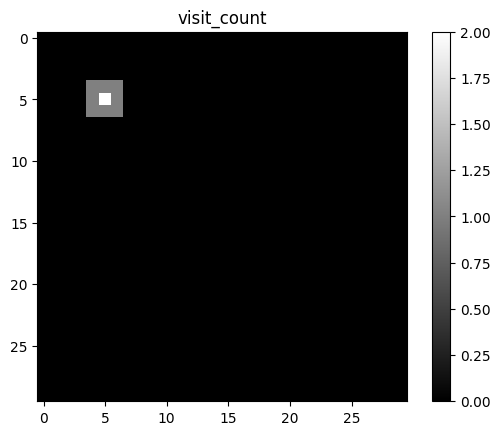

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Time step: 1


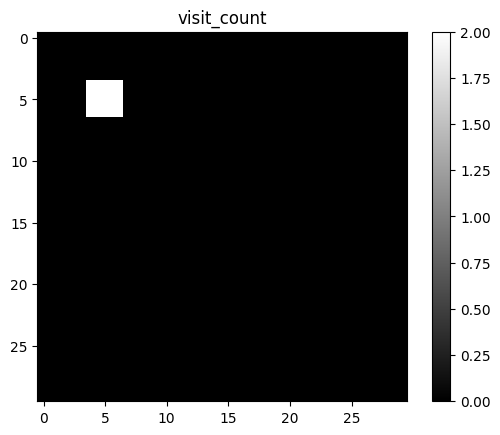

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Time step: 2


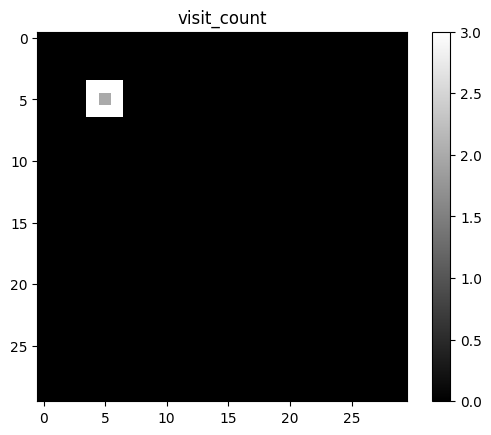

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Time step: 3


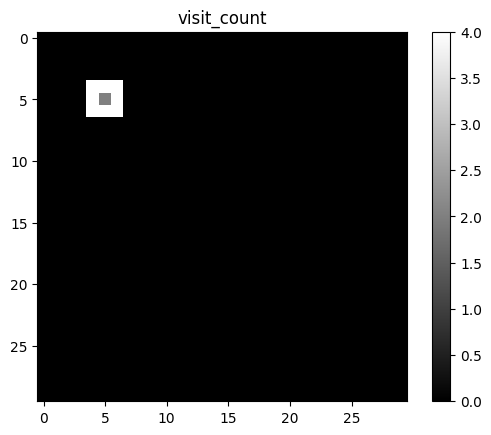

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Time step: 4


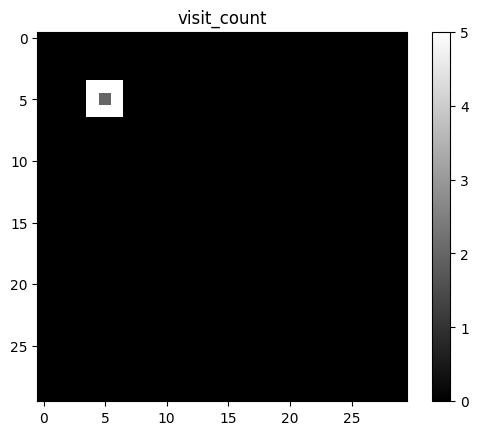

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 99ms/step
target after update: -1.0678885248489678
1/1 [==============================] - 0s 48ms/step
Epoch 1/50
1/1 [==============================] - 1s 526ms/step - loss: 0.2944
Epoch 2/50
1/1 [==============================] - 0s 14ms/step - loss: 0.2134
Epoch 3/50
1/1 [==============================] - 0s 15ms/step - loss: 0.1577
Epoch 4/50
1/1 [==============================] - 0s 14ms/step - loss: 0.1280
Epoch 5/50
1/1 [==============================] - 0s 19ms/step - loss: 0.1142
Epoch 6/50
1/1 [==============================] - 0s 16ms/step - loss: 0.1102
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0997
Epoch 8/50
1/1 [==============================] - 0s 14ms/step - loss: 0.0784
Epoch 9/50
1/1 [==============================] - 0s 15ms/step - loss: 0.0553
Epoch 10/50
1/1 [===================

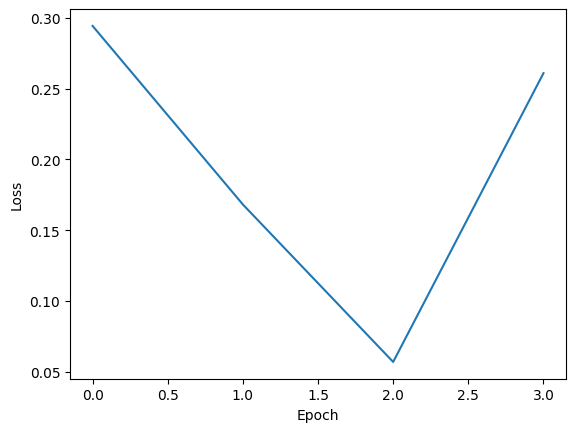

Time step: 5


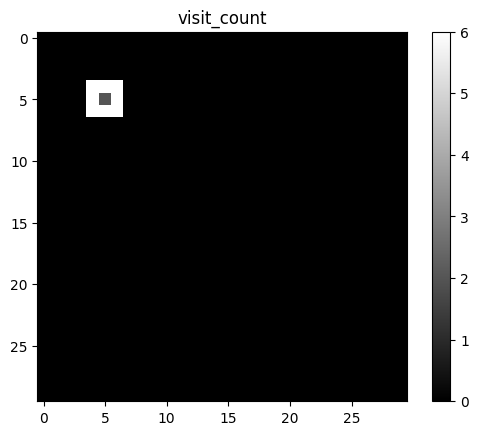

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 15ms/step
target after update: -1.198943326473236
1/1 [==============================] - 0s 14ms/step
Epoch 1/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0412
Epoch 2/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0317
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0194
Epoch 4/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0102
Epoch 5/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0059
Epoch 6/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0054
Epoch 7/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0070
Epoch 8/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0087
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0104
Epoch 10/50
1/1 [=====================

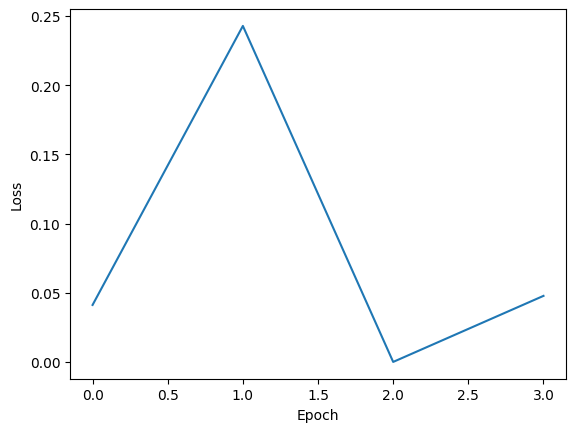

Time step: 6


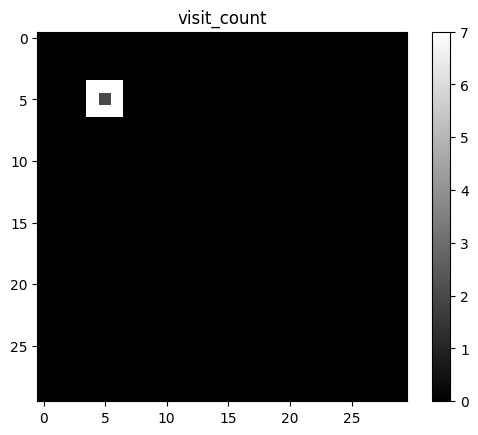

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 15ms/step
target after update: -1.1171590227074921
1/1 [==============================] - 0s 16ms/step
Epoch 1/50
1/1 [==============================] - 0s 12ms/step - loss: 2.0377e-05
Epoch 2/50
1/1 [==============================] - 0s 11ms/step - loss: 3.8038e-05
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 5.0994e-05
Epoch 4/50
1/1 [==============================] - 0s 11ms/step - loss: 5.3607e-05
Epoch 5/50
1/1 [==============================] - 0s 11ms/step - loss: 4.6606e-05
Epoch 6/50
1/1 [==============================] - 0s 12ms/step - loss: 3.5353e-05
Epoch 7/50
1/1 [==============================] - 0s 14ms/step - loss: 2.6003e-05
Epoch 8/50
1/1 [==============================] - 0s 12ms/step - loss: 2.1939e-05
Epoch 9/50
1/1 [==============================] - 0s 11ms/step - loss: 2.2493e-05
E

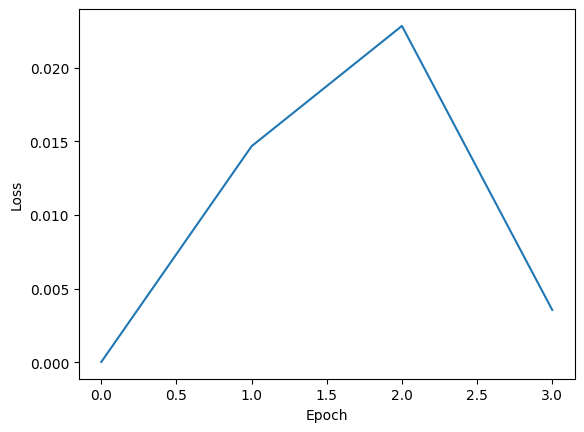

Time step: 7


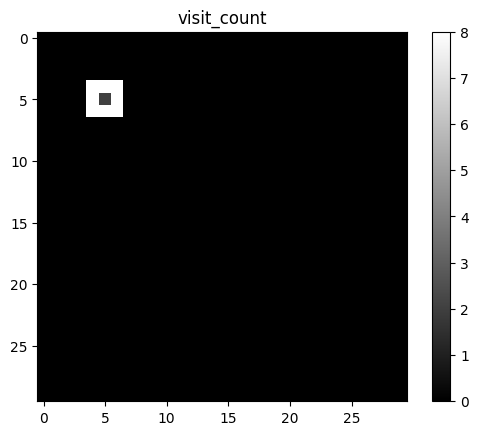

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 15ms/step
target after update: -1.1236602231115103
1/1 [==============================] - 0s 14ms/step
Epoch 1/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0314
Epoch 2/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0235
Epoch 3/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0177
Epoch 4/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0179
Epoch 5/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0187
Epoch 6/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0153
Epoch 7/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0090
Epoch 8/50
1/1 [==============================] - 0s 11ms/step - loss: 0.0048
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 10/50
1/1 [====================

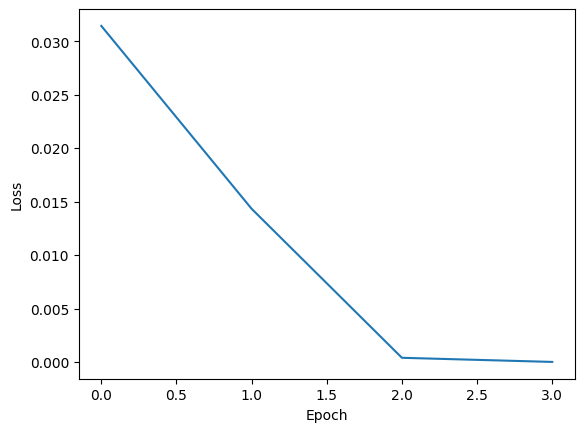

Time step: 8


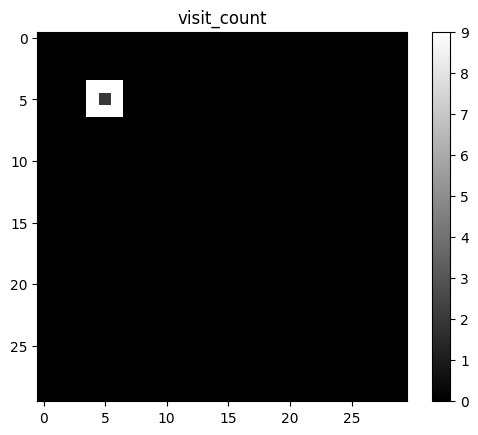

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 15ms/step
target after update: -1.1195812519080939
1/1 [==============================] - 0s 15ms/step
Epoch 1/50
1/1 [==============================] - 0s 12ms/step - loss: 2.4290e-05
Epoch 2/50
1/1 [==============================] - 0s 11ms/step - loss: 2.0506e-05
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 1.6357e-05
Epoch 4/50
1/1 [==============================] - 0s 12ms/step - loss: 1.4383e-05
Epoch 5/50
1/1 [==============================] - 0s 11ms/step - loss: 1.4517e-05
Epoch 6/50
1/1 [==============================] - 0s 11ms/step - loss: 1.4699e-05
Epoch 7/50
1/1 [==============================] - 0s 11ms/step - loss: 1.3150e-05
Epoch 8/50
1/1 [==============================] - 0s 12ms/step - loss: 9.9572e-06
Epoch 9/50
1/1 [==============================] - 0s 12ms/step - loss: 6.7176e-06
E

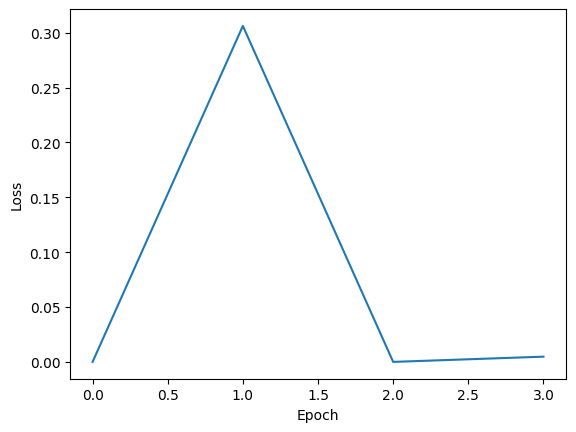

Time step: 9


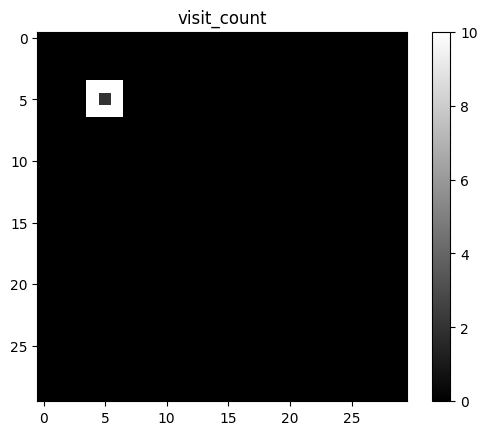

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Start training DQN model with batch size: 4
1/1 [==============================] - 0s 14ms/step
target after update: -2.320803940296173
1/1 [==============================] - 0s 15ms/step
Epoch 1/50
1/1 [==============================] - 0s 11ms/step - loss: 0.3456
Epoch 2/50
1/1 [==============================] - 0s 13ms/step - loss: 0.2667
Epoch 3/50
1/1 [==============================] - 0s 12ms/step - loss: 0.2355
Epoch 4/50
1/1 [==============================] - 0s 13ms/step - loss: 0.1894
Epoch 5/50
1/1 [==============================] - 0s 11ms/step - loss: 0.1642
Epoch 6/50
1/1 [==============================] - 0s 12ms/step - loss: 0.1355
Epoch 7/50
1/1 [==============================] - 0s 12ms/step - loss: 0.0837
Epoch 8/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0504
Epoch 9/50
1/1 [==============================] - 0s 13ms/step - loss: 0.0307
Epoch 10/50
1/1 [=====================

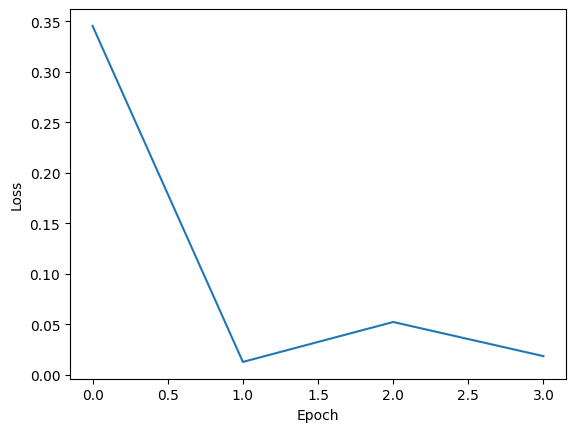

In [7]:
# Track rewards for plotting
rewards_list = []
time_step_rewards = []

for episode in range(n_episodes): # 训练多少张图
    state = env.reset()
    # print(np.array(state[0]).shape)
    state,_ = prepare_state(state)
    # state = np.reshape(state, [1, *state.shape])
    total_reward = 0
    time_step_rewards.append(total_reward)
    
    for time_step in range(time_steps):  # 每张图训练小车走至多多少步
        print(f"Time step: {time_step}")
        action = select_action(state, epsilon)
        next_state, reward, done, _ = env.step(action)
        env.render(map_type="visit_count")
        next_state,_ = prepare_state(next_state)
        # next_state = np.reshape(next_state, [1, *state_size])
        
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        time_step_rewards.append(total_reward)

        if done:
            print(f"Episode: {episode+1}/{n_episodes}, Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break

        if len(replay_buffer) > batch_size: # 当步数大于batch size时开始训练
            print(f"Start training DQN model with batch size: {batch_size}")
            losses = train_dqn(batch_size)
            plt.plot(losses)
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            # print(f"Training DQN model with batch size: {batch_size}")
    
    rewards_list.append(total_reward)
    
    # Decay epsilon after each episode
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

# Plotting the rewards
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.plot(time_step_rewards)
# plt.xlabel('Episode')
# plt.ylabel('Total Reward')
